# validating BGS spectral simulations 
This notebook is a tutorial on predicting the redshift success rate for a given sky brightness and exposure time. The predicted redshift success rate can be compared to the redshift success rate measured from visual inspection to validate the spectral simulations. 

To predict the redshift success rate for a given exposure, in this notebook, we
1. read in a sky brightness and exposure time for an arbitrary CMX exposure
2. generate spectral simulations for this exposure using `feasibgs`
3. run spectral simulations through redrock

This notebook uses the master DESI jupyter kernel. See [wiki page](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) for details on how to set up a DESI jupyter kernel.

In [1]:
# first lets install the python package `feasibgs`, a python package for the BGS spectral simulations
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-c5eu8lpn
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-c5eu8lpn
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47052 sha256=4337a36a49de17073f2b7e70dd089bd83d539fb150ff2dab42d8d8e9908f78ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-suhr91k4/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs
  Attempting uninstall: feasibgs
    Found existing installation: feasibgs 0.1
    Uninstalling feasibgs-0.1:
      Successfully uninstalled feasibgs-0.1


In [2]:
import os, sys
import numpy as np

In [3]:
sys.path.append(os.path.join(os.environ['HOME'], '.local/lib/python3.8/site-packages'))

In [28]:
import os 
import numpy as np 
import fitsio
# --- feasibgs --- 
from feasibgs import util as UT
from feasibgs import cmx as BGS_cmx
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import forwardmodel as FM 

In [5]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# sky brightness
You can use whichever sky brightnesses you want for the rest of the notebook. But for convenience, in this notebook we'll use preprocessed sky brightnesses from DESI CMX data. More specifically, we'll use the median sky surface brightness from sky fibers on tile `66003` and exposure `55654`, which had `450s` exposure time.

For details on how the CMX sky brightnesses were preprocessed see [`feasibgs/cmx.py`](https://github.com/desi-bgs/feasiBGS/blob/f29780ad85edf3a8d62e71eda34a82f0bf225044/feasibgs/cmx.py#L62)

In [6]:
# function to load the preprocessed CMX sky data 
BGS_cmx.cmx_skies?

Signature: BGS_cmx.cmx_skies()
Docstring:
sky surface brightnesses from sky fibers from the CMX exposures. The
sky surface brightnesses are generated from the flat fielded sky data
that's throughput corrected. 

Return
------
skies : dictionary
    dictionary that contains data on sky fibers for a given (tile, date,
    exposure, and spectrograph). The following keys are available in the
    output dictionary: 
    - `tileid`, `date`, `mjd`, `expid`, `spectrograph`
    - observing conditions: `airmass`, `moon_ill`, `moon_alt`, `moon_sep`,
      `sun_alt`, `sun_sep`, `transparency`, `transp_min`, `transp_max`,
      `fwhm`, `exptime`
    - surface brightnesses: `sky_sb_b`, `sky_sb_r`, `sky_sb_z`,
File:      ~/.local/lib/python3.8/site-packages/feasibgs/cmx.py
Type:      function


In [7]:
def quick_coadd(waves, sbrights):
    ''' quick hack to combine wavelengths and surface brightnesses of the 3
    cameras...
    '''
    from scipy.interpolate import interp1d
    from desimodel.io import load_throughput
    # read nominal dark sky surface brightness
    wavemin = load_throughput('b').wavemin - 10.0
    wavemax = load_throughput('z').wavemax + 10.0
    outwave = np.arange(round(wavemin, 1), wavemax, 0.8) 
    
    sbrights_interp = [] 
    for wave, sbright in zip(waves, sbrights): 
        fintrp = interp1d(wave, sbright, fill_value=0., bounds_error=False) 
        sbrights_interp.append(fintrp(outwave))
    
    outsbright = np.amax(sbrights_interp, axis=0) 
    return outwave, outsbright 

In [8]:
skies = BGS_cmx.cmx_skies()
cmx_exp = ((skies['tileid'] == 66003) & (skies['expid'] == 55654))

Isky = quick_coadd(
    [skies['wave_%s' % arm] for arm in ['b', 'r', 'z']], 
    [np.median(skies['sky_sb_%s' % arm], axis=0) for arm in ['b', 'r', 'z']])

In [9]:
exptime = skies['exptime'][cmx_exp][0]
airmass = np.median(skies['airmass'][cmx_exp])
print('airmass = %.2f' % airmass)
print('exposure time = %.1fs' % exptime)

airmass = 1.27
exposure time = 450.0s


(0.0, 10.0)

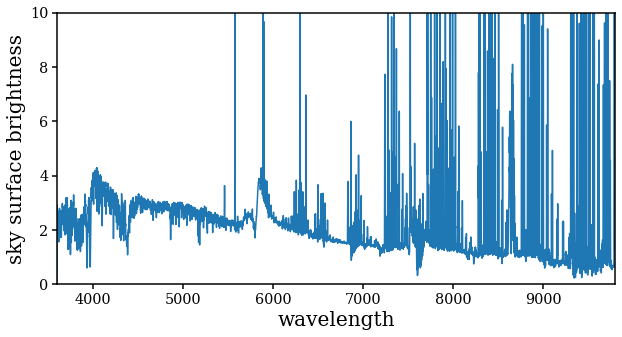

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(Isky[0], Isky[1])
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

# generate BGS spectral simulations for the exposure
We've read in the sky brightness for the exposure we want to simulate. Next we'll use the BGS spectral simulation to simulate spectra for this exposure. 

We begin by reading in noiseless BGS source spectra then run it through the `feasibgs` forward model. For details on how the BGS source spectra are constructed see [`feasibgs/spectral_sims.py`](https://github.com/desi-bgs/feasiBGS/blob/63975b1e60f6f93f3b5020ee51ca565f325b918d/feasibgs/spectral_sims.py#L38)

In [11]:
# function for reading in BGS source spectra
BGS_spec_sim.simulated_GAMA_source_spectra?

Signature: BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True)
Docstring:
read GAMA-matched fiber-magnitude scaled BGS source spectra 
These source spectra are created for GAMA objects. their spectra is 
constructed from continuum that's template matched to the broadband
colors and emission lines from GAMA data (properly flux calibrated). 
Then the spectra is scaled down to the r-band fiber magnitude. They 
therefore do not require fiber acceptance fractions. 
File:      ~/.local/lib/python3.8/site-packages/feasibgs/spectral_sims.py
Type:      function


In [12]:
# read in source wavelength, flux, and galaxy properties. We've turned off emission
# lines to be more conservative about the redshift success rate.
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=False) 

In [13]:
# extract true redshift and r-band magnitude for the simulated galaxies
ztrue = prop['zred'] # redshift
r_mag = prop['r_mag'] # Legacy Survey r mag

Now we can run these source spectra through the BGS forward model and save it to file

In [14]:
fdesi = FM.fakeDESIspec()
bgs = fdesi.simExposure(wave_s, flux_s, exptime=exptime, airmass=airmass, Isky=Isky, filename='bgs_spectral_sim.fits')

(-5.0, 10.0)

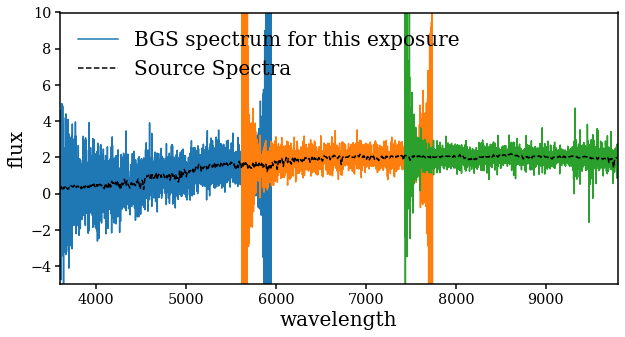

In [25]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for band in ['b', 'r', 'z']: 
    sub.plot(bgs.wave[band], bgs.flux[band][1], label={'b': 'BGS spectrum for this exposure', 'r':None, 'z':None}[band])
sub.plot(wave_s, flux_s[1], c='k', ls='--', label='Source Spectra')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-5, 10)

# run `redrock` on spectral sims
Now that we have a simulated BGS spectra, lets run them through `redrock`. This will take a while so go grab a coffee ... or five

In [26]:
!rrdesi -o redrock.bgs_spectral_sim.h5 -z zbest.bgs_spectral_sim.fits bgs_spectral_sim.fits 

Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1000 targets: 8.8 seconds
DEBUG: Read templates from /global/cscratch1/sd/chahah/redrock-templates
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-st

# calculate redshift success rate
We can now use outputs from `redrock` to estimate the BGS redshift success rate for the exposure. We'll be using a number of convenience functions in `feasibgs`.

In [31]:
# read redrock output
rr = fitsio.read('zbest.bgs_spectral_sim.fits')

# redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
zsuccess = UT.zsuccess(rr['Z'], ztrue, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)

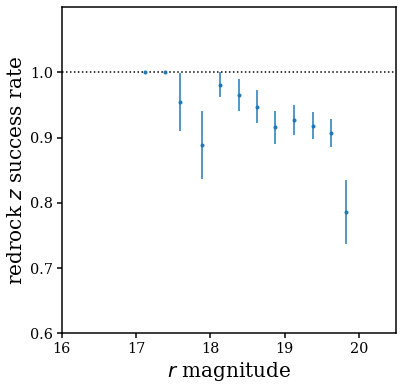

In [35]:
# calculate redshift success rate
wmean, rate, err_rate = UT.zsuccess_rate(r_mag, zsuccess, range=[15, 22], nbins=28, bin_min=10)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot([16, 21], [1, 1], c='k', ls=':')
sub.errorbar(wmean, rate, err_rate, fmt='.C0')
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(16, 20.5)
sub.set_ylabel('redrock $z$ success rate', fontsize=20)
sub.set_ylim(0.6, 1.1)
sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.])

Now you can validate the BGS spectral simulations by comparing the redshift success rate predicted by the BGS spectral simulations for this exposure to the actual redshift success rate we observe!